# 04a Rank CATE estimators GI

In the previous notebook, we saw that estimators do not have good prediction performance, and neither are  
they sufficiently stable in general. On the other hand, the banded ordering of individuals generalizes. In  
this notebook, we measure this generalization performance in terms of the $t$-statistic. We rank the  
various estimators w.r.t. this statistic, and select the ones with which to form an ensemble.

The data perturbations are:  
1. No perturbation  
2. Stratified CV split with different random seed  
3. Another stratified CV split with different random seed  
4. CV split using enrollment time to define folds  
5. Replacing overweight feature with obese (using a different BMI threshold)  
6. Changing age threshold for elderly feature from 65 to 60  
7. Changing the outcome of interest to all GI events instead of just confirmed GI events  

### Contents:
1. Set up  
1.1. Create, save and/or load the scores data frame  
2. Aggregate the $t$-statistics in various ways  
2.1. Aggregate within each data perturbation  
2.2. Aggregate within each q value  
2.3. Aggregate over everything  
3. $t$-statistic variability  
4. Selecting the top estimators  
4.1. Further investigation and plots  
4.2. Outputting names of top estimators

## 1. Set up

In [2]:
# Standard imports
import numpy as np
import pandas as pd
import sys
import copy
import random
import joblib

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib as mpl
import pylab

# Import own methods
from methods.cate_estimator_validation import (get_estimator_scores, aggregate_estimator_scores, 
                                               get_t_r2_statistics)

Failed to import duecredit due to No module named 'duecredit'


If scores are already cached, load them instead of running 1.1.

### 1.1. Create, save and/or load the scores data frame

Compute the t-statistics for the different estimators across different folds and data perturbations. Store the result in the  data frame ``scores_df``.

In [3]:
# Load the scores data frame
outcome_name = "fausebal"
q_values = np.array([0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5])
dir_neg = False
try: 
    scores_df = joblib.load(f"output/analysis/{outcome_name}/{outcome_name}_scores_df.pkl")
except:
    file_path = f"output/analysis/{outcome_name}/{outcome_name}_fitted_libraries.pkl"
    fitted_libraries = joblib.load(file_path)
    scores_df = get_estimator_scores(fitted_libraries, q_values, 
                                    dir_neg=dir_neg, kind = "val")
    joblib.dump(scores_df, f"output/analysis/{outcome_name}/{outcome_name}_scores_df.pkl")
    del fitted_libraries

d:\statistics\jofe\causal-targeting-main\methods\causal_functions.py:21: RuntimeWarning: Mean of empty slice.
  ATE_ = y1_obs.mean() - y0_obs.mean()
d:\statistics\jofe\causal-targeting-main\venv\Lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
d:\statistics\jofe\causal-targeting-main\methods\causal_functions.py:21: RuntimeWarning: Mean of empty slice.
  ATE_ = y1_obs.mean() - y0_obs.mean()
d:\statistics\jofe\causal-targeting-main\venv\Lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
d:\statistics\jofe\causal-targeting-main\methods\causal_functions.py:21: RuntimeWarning: Mean of empty slice.
  ATE_ = y1_obs.mean() - y0_obs.mean()
d:\statistics\jofe\causal-targeting-main\venv\Lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(

## 2. Aggregate the $t$-statistics in various ways

### 2.1. Aggregate within each data perturbation

In [4]:
results_df = aggregate_estimator_scores(scores_df, aggregation_func_name="mean", 
                                        group_by="perturbation", dir_neg=dir_neg)
results_df["mean"] = results_df.apply(np.mean, axis = 1)

In [5]:
results_df.round(2)

pert=none  pert=cv_1  pert=cv_0  mean
estimator                                             
s_xgb                 1.24       0.95       0.18  0.79
s_rf                 -0.07      -0.18       0.04 -0.07
t_lasso               0.79      -0.52       0.19  0.15
t_logistic            5.58       6.16       1.32  4.35
t_rf                 -0.94      -1.60      -0.20 -0.91
t_xgb                -0.17      -0.00       0.08 -0.03
x_lasso              -0.01       0.01      -0.01 -0.01
x_logistic            0.99       1.48       2.54  1.67
x_rf                 -0.81      -0.25      -0.52 -0.53
x_xgb                -0.01       0.01      -0.01 -0.01
r_lassolasso         -0.01       0.01      -0.01 -0.01
r_lassoxgb            2.01       1.40       1.33  1.58
r_lassorf             1.18       0.75       0.76  0.89
r_rflasso            -0.01       0.01      -0.01 -0.01
r_rfrf               -0.66      -1.02      -0.90 -0.86
r_rfxgb               0.22       1.53       1.10  0.95
r_xgblasso           -0.01       0.01      -0.01 -0.01
r_xgbrf               0.96       0.59       0.96  0.84
r_xgbxgb              0.39       0.32       0.34  0.35
causal_tree_1         0.66      -0.17      -0.15  0.12
causal_tree_2        -0.11       0.39       0.32  0.20
causal_forest_1      -0.70       0.20      -0.49 -0.33
causal_forest_2      -0.29       0.46      -0.66 -0.16

In [6]:
results_df = aggregate_estimator_scores(scores_df, aggregation_func_name="rank_mean", 
                                        group_by="perturbation", dir_neg=dir_neg)
results_df["mean"] = results_df.apply(np.mean, axis = 1)

In [7]:
results_df.sort_values("mean").round(2)

pert=none  pert=cv_1  pert=cv_0   mean
estimator                                              
t_logistic            4.40       6.30       6.61   5.77
r_lassoxgb            5.40       7.81       7.70   6.97
r_xgbrf               8.78       9.15       6.98   8.30
r_rfxgb              11.29       7.08       7.08   8.48
r_lassorf             9.22       8.70       7.80   8.57
r_xgbxgb              9.29      10.39      10.60  10.09
s_xgb                11.28       9.32      11.15  10.58
causal_tree_2        12.62      10.05       9.80  10.82
r_xgblasso           11.24      11.92      12.24  11.80
x_xgb                11.18      11.92      12.35  11.82
x_lasso              11.24      11.92      12.35  11.84
r_rflasso            11.24      11.92      12.35  11.84
r_lassolasso         11.24      11.92      12.35  11.84
causal_tree_1         9.93      12.92      12.72  11.86
x_logistic           13.12      13.31       9.44  11.96
t_xgb                13.12      12.40      10.72  12.08
s_rf                 11.60      13.62      11.61  12.28
t_lasso              10.40      14.98      12.78  12.72
causal_forest_2      13.78       9.93      17.20  13.63
causal_forest_1      15.92      11.15      14.80  13.96
x_rf                 16.50      13.50      15.82  15.28
t_rf                 16.62      19.08      13.40  16.37
r_rfrf               16.03      16.68      16.44  16.38

### 2.2. Aggregated within each q value

In [8]:
results_df = aggregate_estimator_scores(scores_df, aggregation_func_name="mean", 
                                        group_by="q_value", dir_neg=dir_neg)
results_df["mean"] = results_df.apply(np.mean, axis = 1)

In [9]:
results_df.sort_values("mean").round(2)

0.05   0.1  0.15   0.2  0.25   0.3  0.35   0.4  0.45   0.5  \
estimator                                                                     
t_rf            -1.46 -1.87 -1.86 -1.45 -1.34 -0.98 -0.93  0.12  0.34  0.68   
r_rfrf          -0.05 -0.59 -0.41 -1.13 -1.26 -1.14 -1.21 -1.00 -0.85 -0.59   
x_rf            -0.44 -0.33 -0.28 -0.35 -0.42 -0.55 -0.57 -0.80 -0.71 -0.77   
causal_forest_1 -0.12 -0.38 -0.37 -0.27 -0.28 -0.45 -0.50 -0.40 -0.30 -0.19   
causal_forest_2 -0.11 -0.30 -0.33 -0.13 -0.09 -0.05  0.01 -0.17 -0.16 -0.25   
s_rf             0.20 -0.22 -0.17  0.03  0.17 -0.18 -0.21 -0.05 -0.01 -0.04   
t_xgb           -0.79 -0.40 -0.24  0.39  0.44  0.42  0.19 -0.09 -0.20 -0.17   
r_rflasso        0.28 -0.13 -0.00  0.09  0.26 -0.10 -0.16  0.01 -0.10 -0.09   
r_lassolasso     0.28 -0.13 -0.00  0.09  0.26 -0.10 -0.16  0.01 -0.10 -0.09   
x_lasso          0.28 -0.13 -0.00  0.09  0.26 -0.10 -0.16  0.01 -0.10 -0.09   
r_xgblasso       0.28 -0.13 -0.00  0.09  0.26 -0.10 -0.16  0.01 -0.10 -0.09   
x_xgb            0.28 -0.13 -0.00  0.09  0.27 -0.10 -0.16  0.01 -0.10 -0.09   
causal_tree_1   -0.06  0.46  0.54  0.24  0.09 -0.06 -0.05  0.05 -0.01 -0.15   
causal_tree_2   -0.07  0.27  0.26  0.25  0.14  0.26  0.28  0.18  0.16  0.16   
t_lasso         -0.36 -0.80 -0.46  0.47  0.74  0.40  0.11  0.38  0.79  0.97   
r_xgbxgb         0.45  0.44  0.32  0.48  0.57  0.20  0.20  0.29  0.31  0.23   
s_xgb            0.96 -0.32 -0.63  0.61  0.85  1.17  1.35  1.54  1.21  0.95   
r_xgbrf          0.64  0.57  0.57  0.81  0.81  0.75  0.80  1.03  1.08  1.42   
r_lassorf        0.84  0.64  0.61  1.01  0.88  0.78  0.69  1.05  1.17  1.14   
r_rfxgb          0.67  0.64  0.73  1.14  1.36  1.22  1.19  1.01  0.84  0.79   
r_lassoxgb       0.74  1.38  1.49  1.94  2.03  1.88  1.83  1.69  1.60  1.30   
x_logistic        NaN   NaN   NaN   NaN   NaN  1.58  1.58  1.79  1.50  1.50   
t_logistic      -0.52 -0.09  0.12  6.31  0.92  7.56  2.82  2.76  2.70  2.28   

                 mean  
estimator              
t_rf            -0.87  
r_rfrf          -0.82  
x_rf            -0.52  
causal_forest_1 -0.33  
causal_forest_2 -0.16  
s_rf            -0.05  
t_xgb           -0.04  
r_rflasso        0.01  
r_lassolasso     0.01  
x_lasso          0.01  
r_xgblasso       0.01  
x_xgb            0.01  
causal_tree_1    0.10  
causal_tree_2    0.19  
t_lasso          0.23  
r_xgbxgb         0.35  
s_xgb            0.77  
r_xgbrf          0.85  
r_lassorf        0.88  
r_rfxgb          0.96  
r_lassoxgb       1.59  
x_logistic       1.59  
t_logistic       2.49

Takeaway: Top estimators for various q values can be different. There is also a fair amount of variability between q values for each estimator.

### 2.3. Aggregated over everything

In [10]:
aggregate_estimator_scores(scores_df, aggregation_func_name="mean", 
                           group_by="none", dir_neg=dir_neg).sort_values("mean").round(2)

mean    std  rank_mean  top_10_freq
estimator                                           
t_rf            -0.91   2.33      16.37         0.20
r_rfrf          -0.86   1.39      16.38         0.22
x_rf            -0.53   0.99      15.28         0.24
causal_forest_1 -0.33   0.93      13.96         0.32
causal_forest_2 -0.16   0.81      13.63         0.30
s_rf            -0.07   0.75      12.28         0.36
t_xgb           -0.03   1.07      12.08         0.49
r_rflasso       -0.01   0.78      11.84         0.37
r_lassolasso    -0.01   0.78      11.84         0.37
x_lasso         -0.01   0.78      11.84         0.37
r_xgblasso      -0.01   0.78      11.80         0.37
x_xgb           -0.01   0.78      11.82         0.38
causal_tree_1    0.12   1.21      11.86         0.45
t_lasso          0.15   2.38      12.72         0.43
causal_tree_2    0.20   0.76      10.82         0.48
r_xgbxgb         0.35   0.91      10.09         0.57
s_xgb            0.79   3.38      10.58         0.56
r_xgbrf          0.84   1.32       8.30         0.70
r_lassorf        0.89   1.63       8.57         0.65
r_rfxgb          0.95   2.01       8.48         0.67
r_lassoxgb       1.58   1.77       6.97         0.73
x_logistic       1.67   5.94      11.96         0.20
t_logistic       4.32  18.00       5.78         0.62

Takeaway: Various methods of ranking the estimators produce pretty consistent results

## 3. $t$-statistic variability

In [11]:
# Plot style settings
plt.style.use("fivethirtyeight")
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

label_size = 22
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
mpl.rcParams['axes.labelsize'] = label_size
mpl.rcParams['axes.titlesize'] = label_size
mpl.rcParams['figure.titlesize'] = label_size
mpl.rcParams['lines.markersize'] = 10
mpl.rcParams['grid.linewidth'] = 2.5
mpl.rcParams['legend.fontsize'] = 20
pylab.rcParams['xtick.major.pad'] = 5
pylab.rcParams['ytick.major.pad'] = 5
mpl.rcParams["figure.figsize"] = [8, 6]
mpl.rcParams['savefig.transparent'] = True

In [12]:
# Get data to make plot
selected_estimators = list(scores_df.index.to_list())
selected_estimators.remove("r_lassoxgb")

selected_estimators = np.array(selected_estimators)
estimator_argsort = np.argsort([scores_df.loc[estimator].mean() for estimator in selected_estimators])
selected_estimators = selected_estimators[estimator_argsort]

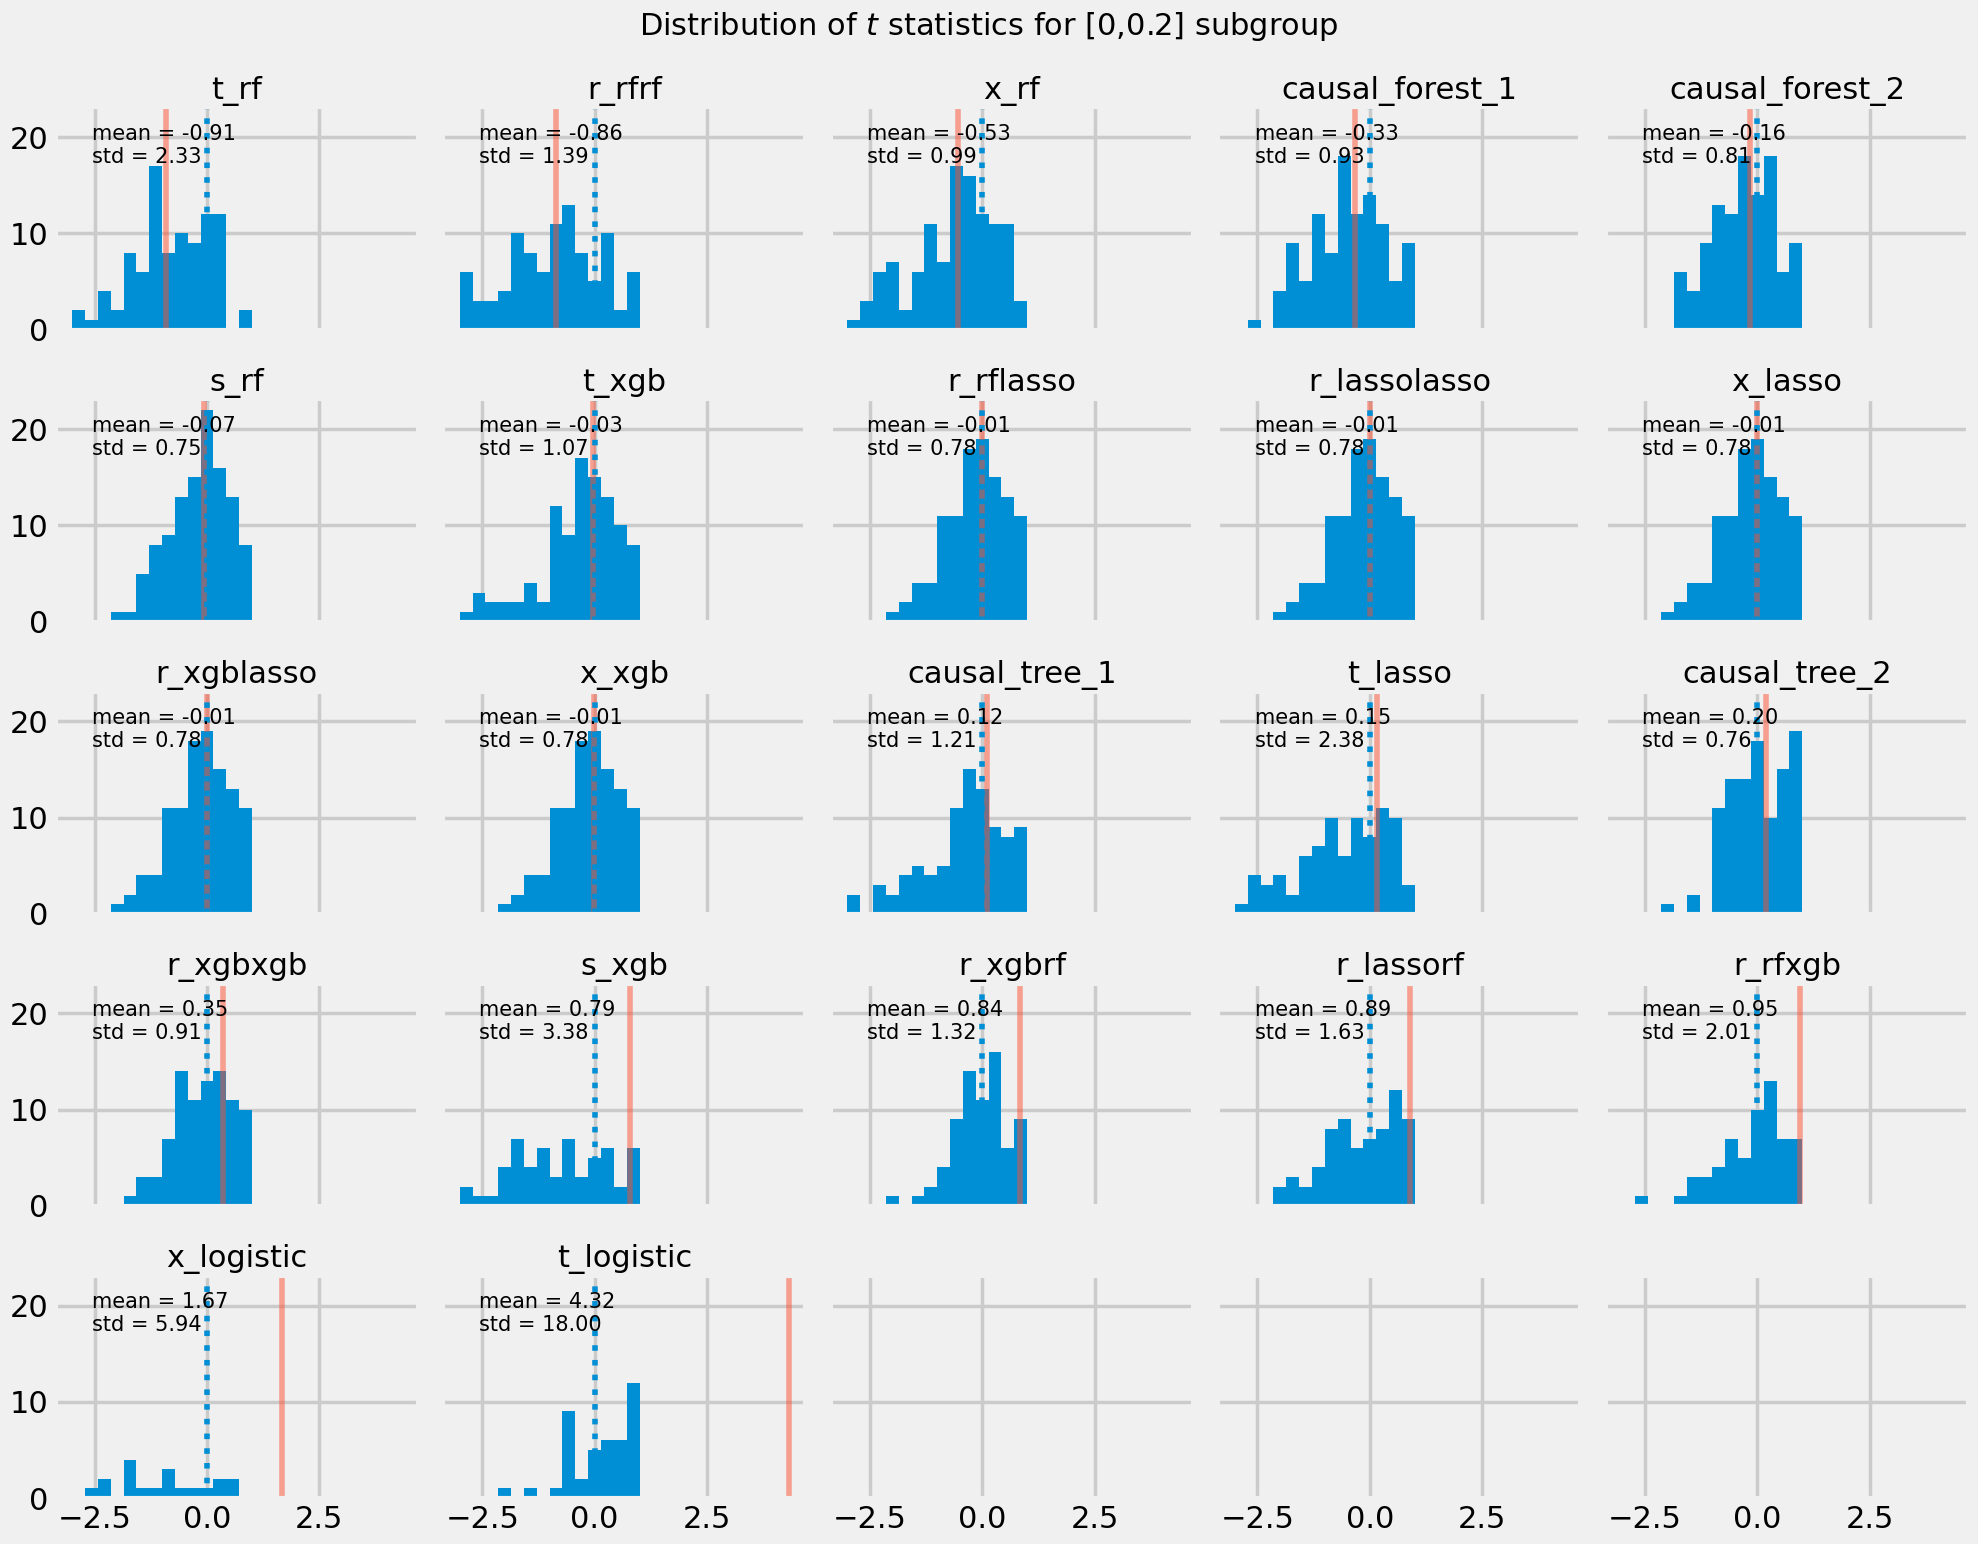

In [13]:
f, axes = plt.subplots(5, 5, figsize=[20, 15], sharex = True, sharey = True)
axes = axes.flatten()
for i, estimator in enumerate(selected_estimators):
    ax = axes[i]
    ax.hist(scores_df.loc[estimator], bins = np.linspace(-3,1,15))
    mean_score = scores_df.loc[estimator].mean()
    score_std = scores_df.loc[estimator].std()
    ax.axvline(mean_score, linestyle='-', color=colors[1], alpha=0.5)
    ax.axvline(0, alpha=1., linestyle=':')
    ax.annotate(f"mean = {mean_score:.2f}\nstd = {score_std:.2f}",
                xy = (.1, .75), xycoords = ax.transAxes,
                fontsize = 15)
    ax.set_title(estimator)
#    ax.set_xticks([-2, -1, 0, 1.])
#    plt.xlim([-2, 1])
plt.tight_layout()
plt.suptitle(r"Distribution of $t$ statistics for [0,0.2] subgroup", y = 1.03)
plt.show()

## 4. Selecting the top estimators

### 4.1. Further investigation and plots

We first return to aggregating $t$-statistics within each perturbation type.

In [14]:
results_df = aggregate_estimator_scores(scores_df, aggregation_func_name="mean", 
                                        group_by = "perturbation", dir_neg=dir_neg)
results_df = results_df.drop(index="r_lassoxgb")
results_df = results_df[[ 'pert=none', 'pert=cv_0', 'pert=cv_1']]
ranking_df = results_df.rank()
ranking_df["max"] = ranking_df.apply(np.max, axis = 1)
ranking_df = ranking_df.sort_values("max")

results_df = results_df.reindex(index=ranking_df.index).round(2)

In [15]:
results_df

pert=none  pert=cv_0  pert=cv_1
estimator                                       
r_rfrf               -0.66      -0.90      -1.02
x_rf                 -0.81      -0.52      -0.25
t_rf                 -0.94      -0.20      -1.60
x_lasso              -0.01      -0.01       0.01
r_lassolasso         -0.01      -0.01       0.01
r_rflasso            -0.01      -0.01       0.01
r_xgblasso           -0.01      -0.01       0.01
s_rf                 -0.07       0.04      -0.18
t_xgb                -0.17       0.08      -0.00
x_xgb                -0.01      -0.01       0.01
causal_forest_1      -0.70      -0.49       0.20
causal_tree_2        -0.11       0.32       0.39
causal_tree_1         0.66      -0.15      -0.17
causal_forest_2      -0.29      -0.66       0.46
t_lasso               0.79       0.19      -0.52
r_xgbxgb              0.39       0.34       0.32
r_xgbrf               0.96       0.96       0.59
r_lassorf             1.18       0.76       0.75
r_rfxgb               0.22       1.10       1.53
s_xgb                 1.24       0.18       0.95
t_logistic            5.58       1.32       6.16
x_logistic            0.99       2.54       1.48

In [16]:
ranking_df

pert=none  pert=cv_0  pert=cv_1   max
estimator                                             
r_rfrf                 4.0        1.0        2.0   4.0
x_rf                   2.0        3.0        4.0   4.0
t_rf                   1.0        5.0        1.0   5.0
x_lasso               10.5        8.5       10.0  10.5
r_lassolasso          10.5        8.5       10.0  10.5
r_rflasso             10.5        8.5       10.0  10.5
r_xgblasso            10.5       11.0       10.0  11.0
s_rf                   8.0       12.0        5.0  12.0
t_xgb                  6.0       13.0        7.0  13.0
x_xgb                 13.0        8.5       10.0  13.0
causal_forest_1        3.0        4.0       13.0  13.0
causal_tree_2          7.0       16.0       15.0  16.0
causal_tree_1         16.0        6.0        6.0  16.0
causal_forest_2        5.0        2.0       16.0  16.0
t_lasso               17.0       15.0        3.0  17.0
r_xgbxgb              15.0       17.0       14.0  17.0
r_xgbrf               18.0       19.0       17.0  19.0
r_lassorf             20.0       18.0       18.0  20.0
r_rfxgb               14.0       20.0       21.0  21.0
s_xgb                 21.0       14.0       19.0  21.0
t_logistic            22.0       21.0       22.0  22.0
x_logistic            19.0       22.0       20.0  22.0

In [17]:
# Run this to get latex code for table
#print(results_df.round(2).to_latex())

In [17]:
joblib.dump([results_df, ranking_df], f"output/analysis/{outcome_name}/{outcome_name}_t_boxplot_data.pkl")

['output/analysis/fausebal/fausebal_t_boxplot_data.pkl']

In [18]:
# Plot style settings
plt.style.use("fivethirtyeight")
label_size = 23
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
mpl.rcParams['axes.labelsize'] = label_size
mpl.rcParams['axes.titlesize'] = label_size
mpl.rcParams['figure.titlesize'] = label_size
mpl.rcParams['lines.markersize'] = 10
mpl.rcParams['grid.linewidth'] = 2.5
mpl.rcParams['legend.fontsize'] = 20
pylab.rcParams['xtick.major.pad'] = 5
pylab.rcParams['ytick.major.pad'] = 5
mpl.rcParams["figure.figsize"] = [8, 6]
mpl.rcParams['savefig.transparent'] = True


plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['figure.edgecolor'] = 'black'
# plt.rcParams['patch.edgecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
# plt.rcParams['grid.color'] = 'black'
SAVE_PATH  = f"figs/{outcome_name}/"


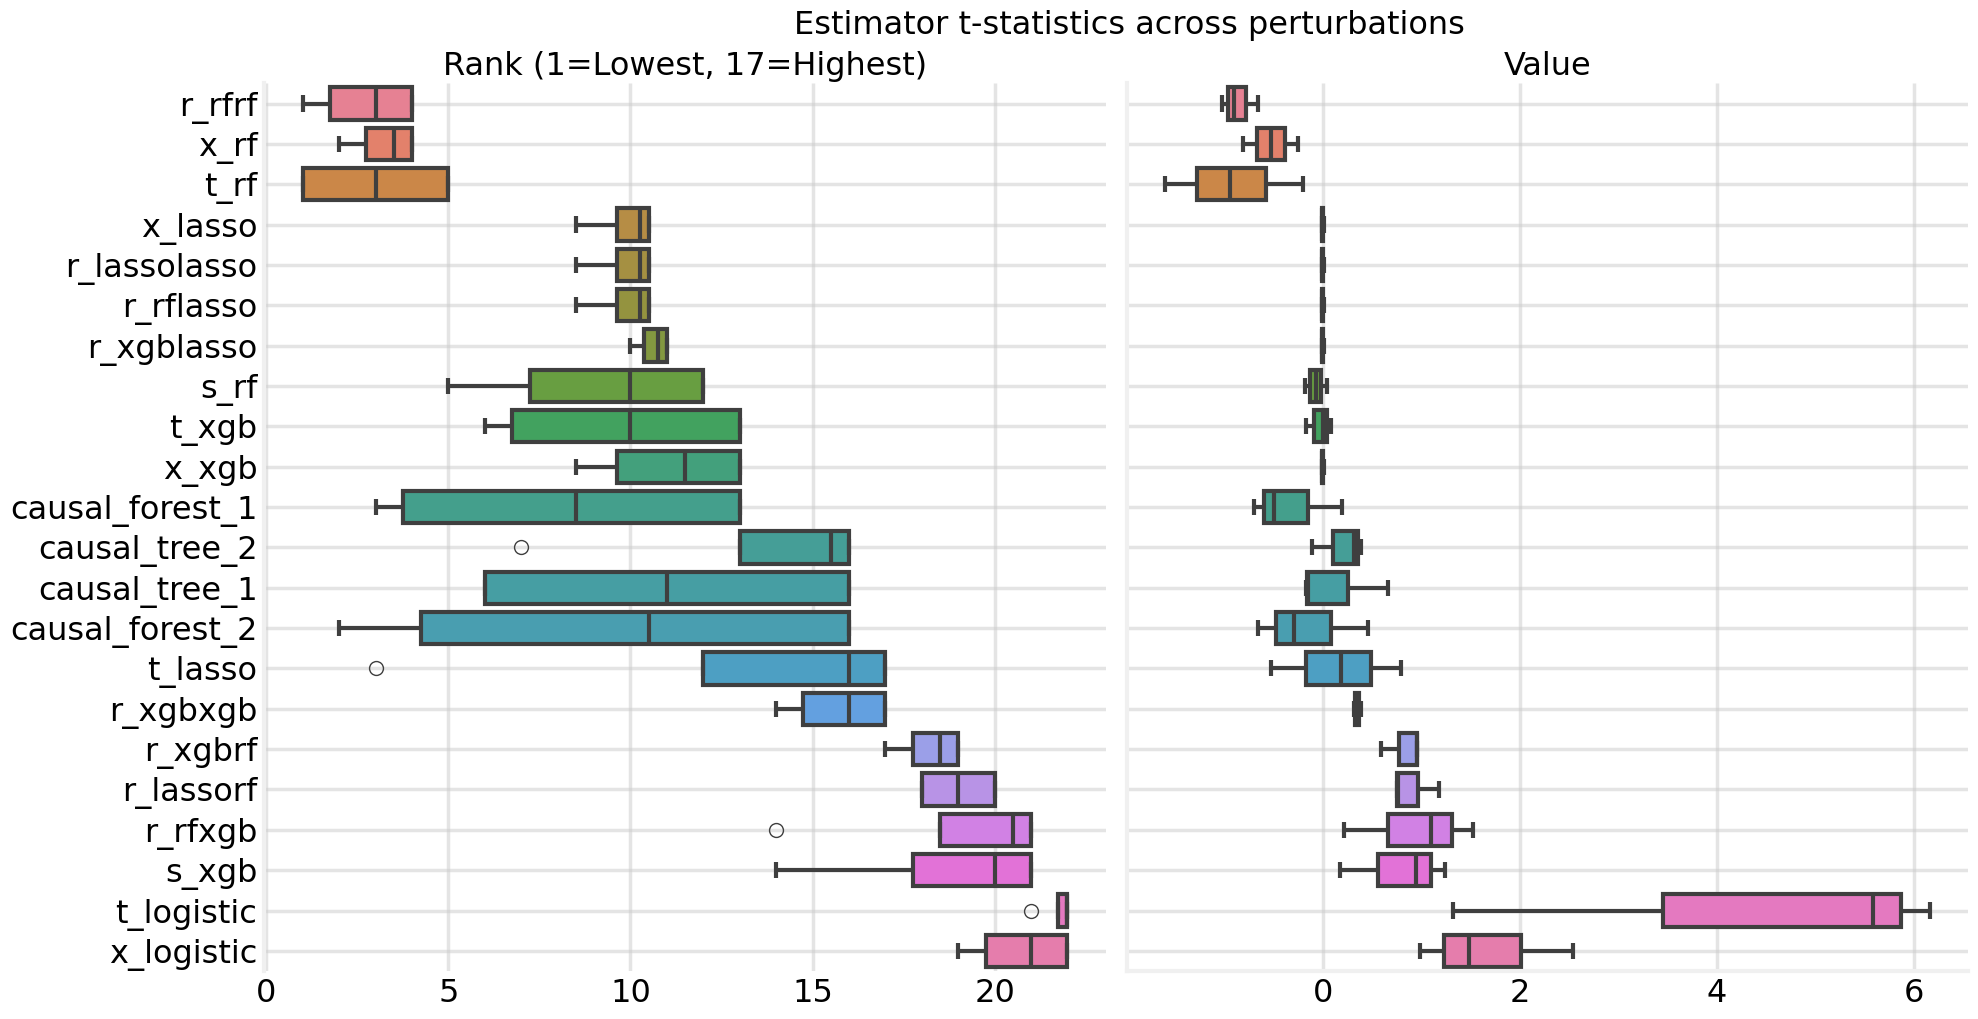

In [19]:
savfig = False
fig, axes = plt.subplots(1, 2, sharey=True, figsize=[20, 10])

ax = axes[0]
box_plot = sns.boxplot(data=ranking_df.T, orient='h',fliersize=10, linewidth=3, ax=ax)
ax.set_ylabel('')
ax.set_title("Rank (1=Lowest, 17=Highest)", x=0.5, y=1)
ax.grid(True, alpha=0.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
# ax.set_xlabel("Value")

ax = axes[1]
box_plot = sns.boxplot(data=results_df.reindex(index=ranking_df.index).T, orient='h',fliersize=10, linewidth=3, ax=ax)
ax.set_ylabel('')
ax.set_title("Value", y=1)
ax.grid(True,  alpha=0.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.set_xlabel("Value")
plt.tight_layout()
plt.suptitle("Estimator t-statistics across perturbations", x=0.57, y=1.02)
if savfig:
    plt.savefig(SAVE_PATH + f"{outcome_name}_scores_rank_estimators.pdf",bbox_inches='tight')
plt.show()
# sns.boxplot(data=monotonicity_df, ax=ax, fliersize=10, linewidth=3)


### 4.2. Outputting names of top estimators

Let's isolate the estimators whose ranks (within each perturbation type) are always at most 10.

In [20]:
ranking_df = ranking_df[~ranking_df.isna().max(axis=1)]
ranking_df["max"] = ranking_df.filter(regex = "pert").max(axis = 1)
ranking_df[ranking_df["max"] < 11]

pert=none  pert=cv_0  pert=cv_1   max
estimator                                          
r_rfrf              4.0        1.0        2.0   4.0
x_rf                2.0        3.0        4.0   4.0
t_rf                1.0        5.0        1.0   5.0
x_lasso            10.5        8.5       10.0  10.5
r_lassolasso       10.5        8.5       10.0  10.5
r_rflasso          10.5        8.5       10.0  10.5

In [21]:
outcome_name = "fausebal"
top_estimator_names = list(ranking_df[ranking_df["max"] < 11].index)
joblib.dump(top_estimator_names, f"output/analysis/{outcome_name}/{outcome_name}_top_estimator_names.pkl")

['output/analysis/fausebal/fausebal_top_estimator_names.pkl']